# Stage 2 Model

## Creating and training the model

### Importing the required libraries.

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow import keras
import os
import seaborn as sns
from matplotlib import pyplot as plt

### List of labels of hand gestures that can be recognised.
Our model can currently recognise 9 gestures. More gestures can be added to the dataset in order to expand the scope of the model.

In [2]:
labels = [
    '1_finger',
    '2_finger',
    '3_finger',
    '4_finger',
    '5_finger',
    'okay',
    'thumbs_up',
    'thumbs_down',
    'call',
]

### Loading the dataset for all the gestures. 
The dataset for each gesture is stored in a .json file. These are all combined into a single dataset which is used to train and test the model.

In [3]:
dataset = []
for i in labels:
    dataset.extend(json.loads(open('data/{}.json'.format(i)).read()))

### Separating into flattened keypoints and label associated with that gesture.

In [4]:
X = []
Y = []
for i in dataset:
    X.append(i['flattened'])
    Y.append(i['label'])

### Count of training images for each gesture.

In [5]:
Counter(Y)

Counter({'1_finger': 702,
         '2_finger': 645,
         '3_finger': 615,
         '4_finger': 628,
         '5_finger': 623,
         'okay': 641,
         'thumbs_up': 542,
         'thumbs_down': 544,
         'call': 539})

In [6]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

### Splitting the dataset into training and testing sets.

In [7]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.2, random_state=20)

### Length of test set for each gesture.

In [8]:
Y_test[0].value_counts()

2_finger       137
1_finger       136
5_finger       130
4_finger       130
3_finger       126
okay           113
thumbs_down    112
thumbs_up      107
call           105
Name: 0, dtype: int64

In [9]:
df = pd.concat([X, Y], axis=1)

In [10]:
Y_train_ = np.array([labels.index(i[0]) for i in Y_train.values])
Y_test_ = np.array([labels.index(i[0]) for i in Y_test.values])

### Shape of the training dataset.

In [11]:
print(X_train.shape)
print(Y_train_.shape)

(4383, 42)
(4383,)


### Creating the model
Creating a Keras Sequential model for the neural network. Our model can work with a minimum of 2 hidden layers with variable number of neurons (in this case 24 and 16 respectively). The hidden layers are activated using the ELU (Exponential Linear Unit) function which provided greater accuracy than RELU or Sigmoid activation functions.

In [12]:
model = keras.Sequential()
model.add(keras.layers.Dense(24, input_shape=(42,)))
model.add(keras.layers.Dense(16,  activation='elu'))
# model.add(keras.layers.Dense(16,  activation='elu'))
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(15))
# model.add(keras.layers.Dense(10, activation='relu'))
# model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(9))


### Summary of the Keras Sequential model
This provides information regarding the type of layers, The output shape of the layer as well as the number of parameters of each layer.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                1032      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________


### Compiling the model
Adam is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks. SparseCategoricalCrossentropy computes the crossentropy loss between the labels and predictions. Keras metrics are functions that are used to evaluate the performance of a deep learning model. Our model uses the 'Accuracy' metric.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Fitting the model
The model is fitted with the training dataset and observing the change in accuracy with each Epoch.

In [15]:
model.fit(X_train.values, Y_train_, epochs=10)

Train on 4383 samples
Epoch 1/10
4383/4383 [==============================] - 1s 220us/sample - loss: 4.2520 - accuracy: 0.3493
Epoch 2/10
4383/4383 [==============================] - 0s 46us/sample - loss: 1.0866 - accuracy: 0.6386
Epoch 3/10
4383/4383 [==============================] - 0s 51us/sample - loss: 0.6366 - accuracy: 0.7919
Epoch 4/10
4383/4383 [==============================] - 0s 46us/sample - loss: 0.4854 - accuracy: 0.8631
Epoch 5/10
4383/4383 [==============================] - 0s 57us/sample - loss: 0.4185 - accuracy: 0.8880
Epoch 6/10
4383/4383 [==============================] - 0s 45us/sample - loss: 0.3793 - accuracy: 0.8948
Epoch 7/10
4383/4383 [==============================] - 0s 47us/sample - loss: 0.3725 - accuracy: 0.8932
Epoch 8/10
4383/4383 [==============================] - 0s 49us/sample - loss: 0.3319 - accuracy: 0.9090
Epoch 9/10
4383/4383 [==============================] - 0s 46us/sample - loss: 0.3000 - accuracy: 0.9211
Epoch 10/10
4383/4383 [=========

### The loss and the accuracy of the test dataset

In [16]:
test_loss, test_acc = model.evaluate(X_test.values,  Y_test_, verbose=2)

1096/1 - 0s - loss: 1.4351 - accuracy: 0.9416


In [17]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

### Making predictions using the test data.

In [18]:
predictions = probability_model.predict(X_test.values)

### Each model is saved separatey in order to moniter performance.

In [31]:
model.save('model2_9_3')

INFO:tensorflow:Assets written to: model2_9_3\assets


### The number of test values and predictions match.

In [20]:
X_test.values.shape

(1096, 42)

In [21]:
len(predictions)

1096

### Creating a confusion matrix using the predictions and the test labels

In [22]:
p1 = np.array([np.argmax(i) for i in predictions])

In [23]:
conf_matrix = pd.DataFrame(tf.math.confusion_matrix(Y_test_, p1).numpy(), index=labels, columns=labels)

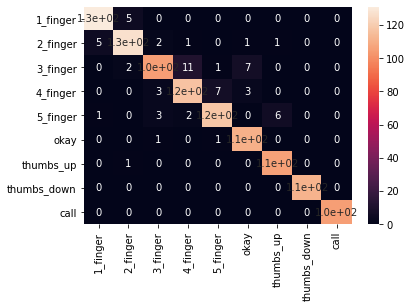

In [24]:
sns.heatmap(conf_matrix, annot=True)

## Incorporating Mode 2 with Model 1 to generate gesture predictions.

### Loading the model

In [25]:
model = tf.keras.models.load_model('model2_9_3')

In [26]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

### The two models communicate via a server

In [27]:
import socketio
sio2 = socketio.Client()

### Defining the server event
In this event, Model 2 recieves data from the server which is the keypoints generated by Model 1.</p><p>Model 2 then uses that data and makes a prediction. That prediction is sent back to the server.

In [28]:
@sio2.event
def connect():
    print('connection established')
    sio2.emit('model2')

@sio2.event
def disconnect():
    print('disconnected from server')
    
@sio2.event
def predict(data):
    predictions = probability_model.predict(np.array([data['m2']]))
    sio2.emit('predictions', {'preds': predictions.tolist()})

### Connecting to the server.

In [30]:
sio2.connect('http://127.0.0.1:8080')

connection established


### Disconnecting from the server.

In [53]:
sio2.disconnect()